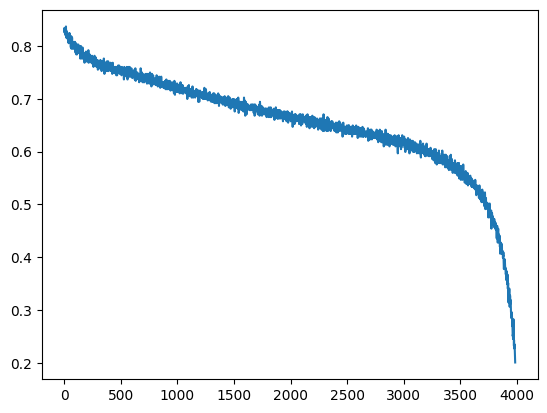

In [31]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Dataset
import maketab as mt
from scipy.signal import savgol_filter as sf

norm_upper = 4
norm_lower = 2
seq_length = 50
hidden_size = 64
learning_rate = 0.001
num_epochs = 100
batch_size = 32

def norm(signal):
    signal = (signal - norm_lower) / (norm_upper - norm_lower)
    signal = signal[50:]
    return signal

def load_data(path_dir='data/5-2-25/'):
    t, signal = mt.battery(path_dir)
    return norm(signal)

train_data = load_data()
#train_data = sf(train_data, seq_length, 1)
plt.plot(train_data)
plt.show()
test_data = load_data(path_dir='data/4-2-25/')

# Generate synthetic time series (sine wave with noise)
#time = np.linspace(0, 50, 1000)
#sine_wave = np.sin(time) + np.exp(time/10)
#noise = np.random.normal(0, 0.1, 1000)
#time_series = sine_wave + noise

In [32]:
class SequenceDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        # The number of possible sequences is len(data) - 2 * sequence_length + 1
        return len(self.data) - 2 * self.sequence_length + 1

    def __getitem__(self, idx):
        input_seq = self.data[idx : idx + self.sequence_length]
        output_seq = self.data[idx + self.sequence_length : idx + 2 * self.sequence_length]        
        return input_seq, output_seq

In [197]:
'''
class ElmanRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(ElmanRNNModel, self).__init__()
        self.input_size = input_size  # seq_length, used as sequence length
        self.hidden_size = hidden_size  # Number of RNN hidden units
        self.output_size = output_size  # seq_length
        self.num_layers = num_layers  # Number of RNN layers
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension: [batch_size, seq_length, 1]
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        out = out[:, :, 0]  # [batch_size, seq_length]
        
        return out

input_size = seq_length  # Sequence length
output_size = seq_length  # Output sequence length

# Instantiate the model
model = ElmanRNNModel(input_size, hidden_size, output_size)
'''

In [192]:
'''
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.input_size = input_size  # seq_length, but treated as sequence length here
        self.hidden_size = hidden_size  # Number of LSTM hidden units
        self.output_size = output_size  # seq_length
        self.num_layers = num_layers  # Number of LSTM layers
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension: [batch_size, seq_length, 1]
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  # [batch_size, seq_length, output_size]
        out = out[:, :, 0]  # Take first feature if fc outputs more, but here it’s fine
        return out

input_size = seq_length  # Sequence length
output_size = seq_length  # Output sequence length

# Instantiate the model
model = LSTMModel(input_size, hidden_size, output_size)
'''

In [33]:
class FeedforwardModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.sig(x)
        x = self.fc2(x)
        return x

# Define model parameters
input_size = seq_length  # Number of input features
output_size = seq_length  # Number of output features

# Instantiate the model
model = FeedforwardModel(input_size, hidden_size, output_size)

In [34]:
dataset = SequenceDataset(train_data, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
        
    for batch_idx, (input_seq, target_seq) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(input_seq)
        loss = criterion(output, target_seq)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
        
        # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

Epoch [10/100], Loss: 0.000954
Epoch [20/100], Loss: 0.000050
Epoch [30/100], Loss: 0.000045
Epoch [40/100], Loss: 0.000047
Epoch [50/100], Loss: 0.000046
Epoch [60/100], Loss: 0.000047
Epoch [70/100], Loss: 0.000045
Epoch [80/100], Loss: 0.000045
Epoch [90/100], Loss: 0.000043
Epoch [100/100], Loss: 0.000045


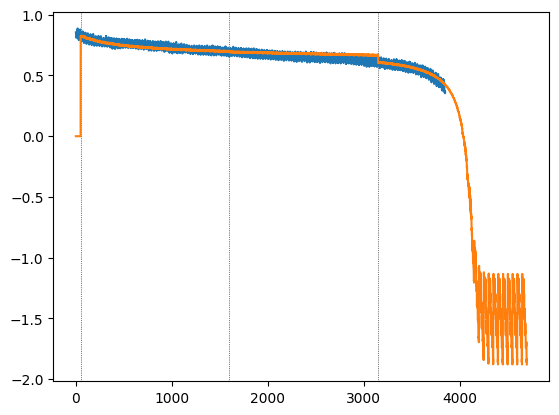

In [35]:
def predict(data, seq_length, theta=30):
    model.eval()
    with torch.no_grad():
        pred = np.empty(0)
        for i in range(0, len(data) - seq_length + 1, seq_length*(theta+1)):
            X = torch.tensor(data[i:i+seq_length], dtype=torch.float32).unsqueeze(0)
            y = model(X)
            y_pred = y.squeeze(0).numpy()
            pred = np.append(pred, y_pred)
            for _ in range(theta):
                y = model(y)
                y_pred = y.squeeze(0).numpy()
                pred = np.append(pred, y_pred)
            plt.axvline(i+seq_length, linestyle=":", color="black", linewidth=0.5)
        plt.plot(data)
        pred = np.append(np.zeros(seq_length), pred)
        plt.plot(pred)
        plt.show()
predict(test_data, seq_length)